In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import keras
import pickle
import os
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D, Activation)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report, roc_curve, auc)
from mlxtend.plotting import plot_confusion_matrix
import cv2
# Base Libraries
from tensorflow.keras.applications import  VGG19, EfficientNetB0, InceptionV3, ResNet50, EfficientNetB3
import numpy as np 
import pandas as pd
import pylab as pl
# Transformation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
# Feature Selection


from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

2024-06-14 18:48:55.381057: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 18:48:55.384863: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-14 18:48:55.436855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 18:48:56.335719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train2=os.listdir("dermnet/train")
train2

['Acne and Rosacea Photos',
 'Exanthems and Drug Eruptions',
 'Systemic Disease',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Urticaria Hives',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Light Diseases and Disorders of Pigmentation',
 'Bullous Disease Photos',
 'Seborrheic Keratoses and other Benign Tumors',
 'Herpes HPV and other STDs Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Lupus and other Connective Tissue diseases',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Warts Molluscum and other Viral Infections',
 'Melanoma Skin Cancer Nevi and Moles',
 'Eczema Photos',
 'Vasculitis Photos',
 'Vascular Tumors',
 'Nail Fungus and other Nail Disease']

In [3]:
cat2=['Melanoma Skin Cancer Nevi and Moles']

cat=['Melanoma Skin Cancer Nevi and Moles',
    'Acne and Rosacea Photos',
    'Atopic Dermatitis Photos',
    'Nail Fungus and other Nail Disease',
    'Seborrheic Keratoses and other Benign Tumors',
    'Psoriasis pictures Lichen Planus and related diseases']

In [4]:
def data_dictionary():
    path_train="dermnet/train/"
    path_test="dermnet/train/"
    list_train=cat
    list_train1=cat2
    train_dictionary={"image_path":[],"target":[]}
    test_dictionary={"image_path":[],"target":[]}
    k=0
    for i in list_train:
        path_disease_train=path_train+i
        image_list_train=os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j            
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k) 
        k+=1
    for i in list_train1:
        path_disease_test=path_test+i
        image_list_test=os.listdir(path_disease_test)
        for j in image_list_test:
            img_path_train=path_disease_test+"/"+j            
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(0)
    train_df=pd.DataFrame(train_dictionary)
    return  train_df

In [5]:
train=data_dictionary()
train.info()
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4298 entries, 0 to 4297
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  4298 non-null   object
 1   target      4298 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 67.3+ KB


,image_path,target
0,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
1,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
2,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
3,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
4,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
...,...,...
4293,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
4294,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
4295,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0
4296,dermnet/train/Melanoma Skin Cancer Nevi and Mo...,0


In [6]:
def auto_levels(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l = cv2.equalizeHist(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

In [7]:
images=[]
label=[]
desired_size = (200, 200)

for i in train['image_path']:
    img=cv2.imread(i)
    # if 'Nail Fungus and other Nail Disease' not in i:
    #     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #     _, thresholded = cv2.threshold(gray, 0, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # if '05Atopic0224' in i:
        #     plt.subplot(1, 2, 1)
        #     plt.title('Thresholded Image')
        #     plt.imshow(thresholded, cmap='gray')

        # if '05Atopic0224' in i:
        #     plt.subplot(1, 2, 1)
        #     plt.title('Original Image')
        #     plt.imshow(img)
            
        # if 'Psoriasis-Guttate-18' in i:
        #     plt.subplot(1, 2, 1)
        #     plt.title('Thresholded Image')
        #     plt.imshow(thresholded, cmap='gray')

        # if 'Psoriasis-Guttate-18' in i:
        #     plt.subplot(1, 2, 1)
        #     plt.title('Original Image')
        #     plt.imshow(img)
            
        # contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # largest_contour = max(contours, key=cv2.contourArea)
        # x, y, w, h = cv2.boundingRect(largest_contour)
        # img = img[y:y+h+50, x:x+w+50]

    # alpha = 1  # коэффициент яркости
    # beta = 2   # коэффициент контрастности

    # img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # img = auto_levels(img)

    matrix = np.array([[1.5, 0.0, 0.0],
                       [0.0, 1.08, 0.0],
                       [0.0, 0.0, 0.6]])
    img = cv2.transform(img, matrix)
    
    # h, w, _ = img.shape

    # if h > desired_size[0]:
    #     img = img[:desired_size[0], :]
    # if w > desired_size[1]:
    #     img = img[:, :desired_size[1]]
        
    # top = max((desired_size[0] - h) // 2, 0)
    # bottom = max(desired_size[0] - h - top, 0)
    # left = max((desired_size[1] - w) // 2, 0)
    # right = max(desired_size[1] - w - left, 0)

    # img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    # if '05Atopic0224' in i:
    #         plt.subplot(1, 2, 2)
    #         plt.title('Cutted Image')
    #         plt.imshow(img)
    
    # if 'Psoriasis-Guttate-18' in i:
    #         plt.subplot(1, 2, 2)
    #         plt.title('Cutted Image')
    #         plt.imshow(img)
    img = cv2.resize(img, desired_size)
    
    images.append(img)
plt.show()

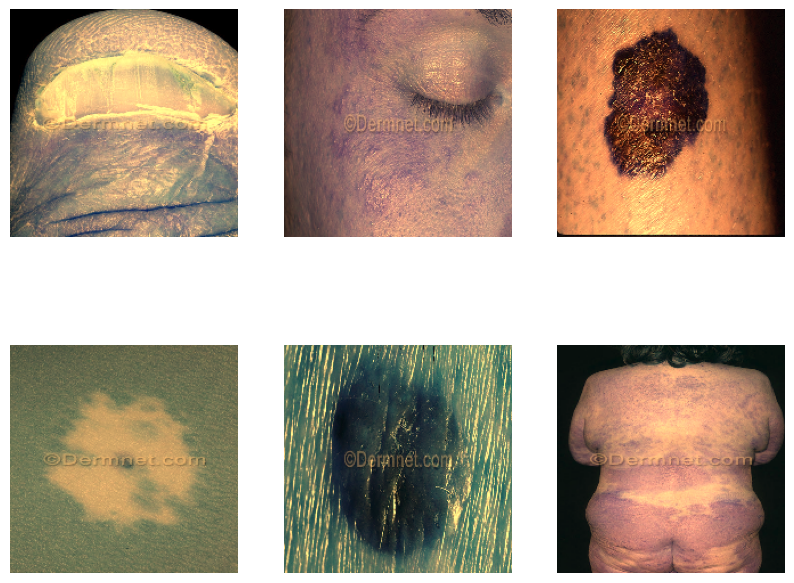

In [8]:
example_list = [image for image in random.sample(images, k=6)]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for ax, img_array in zip(axes.ravel(), example_list):
    ax.imshow(img_array)
    ax.axis('off')

plt.show()

In [9]:
label=train['target']

print(len(label))
len(images)

4298


4298

In [10]:
def add_random_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

In [11]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [12]:
def augment_images(images, targets):
    augmented_images = []
    augmented_targets = []

    for img, target in zip(images, targets):
        # Original image
        augmented_images.append(img)
        augmented_targets.append(target)
        
        # Rotate image by a random angle between -45 and 45 degrees
        angle = random.uniform(-45, 45)
        rotated_img = rotate_image(img, angle)
        augmented_images.append(rotated_img)
        augmented_targets.append(target)
        
        # Add random noise to image
        noisy_img = add_random_noise(img)
        augmented_images.append(noisy_img)
        augmented_targets.append(target)
        
    return augmented_images, augmented_targets

In [13]:
# images, label = augment_images(images, label)

# print(len(label))
# len(images)

In [14]:
# example_list = [image for image in random.sample(images, k=6)]

# fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# for ax, img_array in zip(axes.ravel(), example_list):
#     ax.imshow(img_array)
#     ax.axis('off')

# plt.show()

In [15]:
# for i in range(10):
#     cv2.imshow('Augmented Image', images[i])
#     cv2.waitKey(0)
# cv2.destroyAllWindows()

In [16]:
data=np.array(images)
label=np.array(label)

print(data.shape)
label.shape

(4298, 200, 200, 3)


(4298,)

In [17]:
vgg_model = VGG19(weights = 'imagenet',  include_top = False, input_shape = (200, 200, 3)) 

for layer in vgg_model.layers : 
    layer.trainable = False

In [18]:
#plot_model(vgg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
model=Sequential([
    Dense(200,activation='relu'),
    Dense(170,activation='relu'),
    Dense(6,activation='softmax')
])

In [20]:
mcp_save = ModelCheckpoint('EnetB0_CIFAR10_TL.keras', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

kf = KFold(n_splits = 3)

In [21]:
acc=[]
num_classes = 6
label = keras.utils.to_categorical(label, num_classes)

label.shape

(4298, 6)

In [22]:
for i in range(3): 
    x_train,x_test, y_train, y_test=train_test_split(data, label, test_size=0.2,random_state = np.random.randint(1,1000, 1)[0])
    print(x_train.shape)
    
    for layer in vgg_model.layers :
        layer.trainable = False
        
    features_train=vgg_model.predict(x_train)
    features_test=vgg_model.predict(x_test)
    print(features_train.shape)
    
    num_train=x_train.shape[0]
    num_test=x_test.shape[0]
    print(num_train)
    print(num_test)
    
    x_test=features_test.reshape(num_test,-1)
    x_train=features_train.reshape(num_train,-1)
    print(x_train.shape)
    print(x_train.shape)

(3438, 200, 200, 3)


2024-06-14 18:49:18.011269: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 412560000 exceeds 10% of free system memory.


108/108 ━━━━━━━━━━━━━━━━━━━━ 1767s 16s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 480s 18s/step
(3438, 6, 6, 512)
3438
860
(3438, 18432)
(3438, 18432)
(3438, 200, 200, 3)


2024-06-14 19:26:52.412246: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 412560000 exceeds 10% of free system memory.


108/108 ━━━━━━━━━━━━━━━━━━━━ 1860s 17s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 470s 17s/step
(3438, 6, 6, 512)
3438
860
(3438, 18432)
(3438, 18432)
(3438, 200, 200, 3)


2024-06-14 20:05:51.843247: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 412560000 exceeds 10% of free system memory.


108/108 ━━━━━━━━━━━━━━━━━━━━ 1757s 16s/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 406s 15s/step
(3438, 6, 6, 512)
3438
860
(3438, 18432)
(3438, 18432)


In [ ]:
history = model.fit(x_train, y_train, epochs=70)

model.save('6class_200.keras')

Epoch 1/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5038 - loss: 6.8577
Epoch 2/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8111 - loss: 0.5697
Epoch 3/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9263 - loss: 0.2140
Epoch 4/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9711 - loss: 0.0985
Epoch 5/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9828 - loss: 0.0628
Epoch 6/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9898 - loss: 0.0542
Epoch 7/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9873 - loss: 0.0510
Epoch 8/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9310 - loss: 0.2710
Epoch 9/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9399 - loss: 0.2352
Epoch 10/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9464 - loss: 0.2307
Epoch 11/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9625 - loss: 0.1619
Epoch 12/70
108/108 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred_train = model.predict(x_train)
y_pred1 = np.argmax(y_pred_train, axis=1)

In [ ]:
y_test_tr = np.argmax(y_train, axis=1)

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
y_pred2=np.argmax(y_pred, axis=1)
y_pred2

In [ ]:
y_test=np.argmax(y_test, axis=1)
y_test

In [ ]:
confusion_matrix_result=confusion_matrix(y_test_tr,y_pred1)

plt.title("skin detection  using VGG19 ")

ax= plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
plt.show()

In [ ]:
confusion_matrix_result=confusion_matrix(y_test,y_pred2)

plt.title("skin detection  using VGG19 ")

ax= plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
plt.show()

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
confusion_matrix=classification_report(y_test_tr,y_pred1)

print(confusion_matrix)

In [ ]:
confusion_matrix=classification_report(y_test,y_pred2)

print(confusion_matrix)

In [ ]:
desired_size = (200, 200)
def predict_skin_disease(image_path):
    model = tf.keras.models.load_model('6class.keras')

    img=cv2.imread(image_path)
    if 'Nail Fungus and other Nail Disease' not in image_path:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresholded = cv2.threshold(gray, 0, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img = img[y:y+h+100, x:x+w+100]

    alpha = 1  # коэффициент яркости
    beta = 2   # коэффициент контрастности

    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    # img = auto_levels(img)

    matrix = np.array([[1.5, 0.0, 0.0],
                       [0.0, 1.08, 0.0],
                       [0.0, 0.0, 0.6]])
    img = cv2.transform(img, matrix)
    
    h, w, _ = img.shape

    # if h > desired_size[0]:
    #     img = img[:desired_size[0], :]
    # if w > desired_size[1]:
    #     img = img[:, :desired_size[1]]
        
    # top = max((desired_size[0] - h) // 2, 0)
    # bottom = max(desired_size[0] - h - top, 0)
    # left = max((desired_size[1] - w) // 2, 0)
    # right = max(desired_size[1] - w - left, 0)

    # img_with_border = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    img = cv2.resize(img, desired_size)
    
    # Make prediction on preprocessed image
    pred = model.predict(img)[0]
    predicted_class = np.argmax(pred)

    return predicted_class


print(predict_skin_disease("dermnet/test/Melanoma Skin Cancer Nevi and Moles/atypical-nevi-19.jpg"))
print(predict_skin_disease("dermnet/test/Acne and Rosacea Photos/acne-cystic-53.jpg"))
print(predict_skin_disease("dermnet/test/Atopic Dermatitis Photos/05atopicAdult1118051.jpg"))
print(predict_skin_disease("dermnet/test/Nail Fungus and other Nail Disease/acute-paronychia-23.jpg"))
print(predict_skin_disease("dermnet/test/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-173.jpg"))
print(predict_skin_disease("dermnet/test/Psoriasis pictures Lichen Planus and related diseases/pityriasis-rosea-9.jpg"))